In [105]:
import torchaudio
torchaudio.set_audio_backend("soundfile")
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch
from torch import nn
from tqdm import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
import os
import warnings
import gc
from copy import deepcopy
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import librosa
import numpy as np
import noisereduce as nr
warnings.filterwarnings("ignore")

# help function

In [106]:
def trim_and_padding(y):
    time_length = 72000
    if 0 < len(y):
        trimmed, index = librosa.effects.trim(reduced_noise, top_db=20, frame_length=512, hop_length=64)
    if len(y) > time_length:
        y = y[0:time_length]
    else: # pad blank
        padding = time_length - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, time_length - len(y) - offset))
    return y


def Noise_Injection(data,noise_factor=1):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def Shifting_Time(data, sampling_rate=16000, shift_max=100, shift_direction='right'):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif self.shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

def Changing_Pitch(data, sampling_rate=16000, pitch_factor = 2):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def Changing_Speed(data, speed_factor=1.5):
    return librosa.effects.time_stretch(data, speed_factor)

aug_method = {}
aug_method[0] = Noise_Injection
aug_method[1] = Shifting_Time
aug_method[2] = Changing_Pitch
aug_method[3] = Changing_Speed

# PATH

In [107]:
X_train_dir = 'train/train/'
X_test_dir = 'public_test/public_test/'
Y_train_path = 'train/meta_train.csv'

# EDA

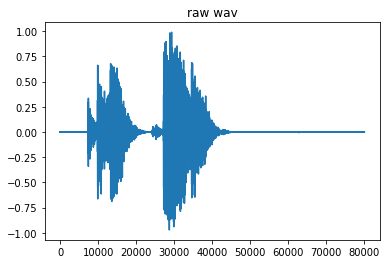

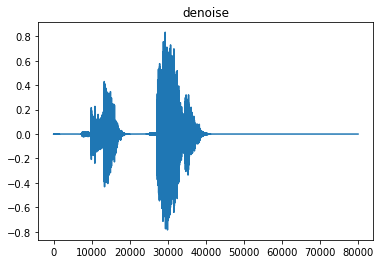

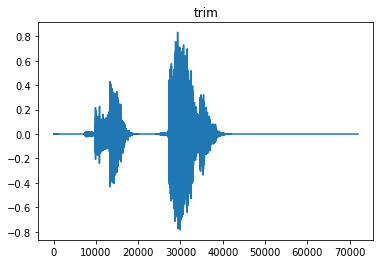

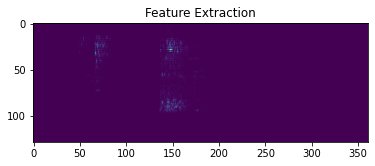

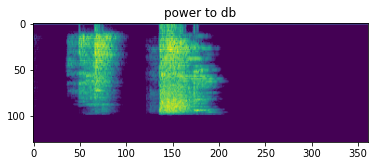

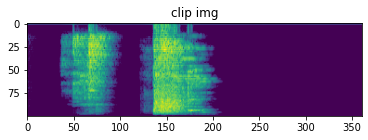

In [108]:
# raw wav
samples, sample_rate = librosa.load(X_train_dir+os.listdir(X_train_dir)[0],sr=16000)
plt.title('raw wav')
plt.plot(samples)
plt.show()

# denoise
noisy_part = samples[0:-1]
reduced_noise = nr.reduce_noise(audio_clip=samples,noise_clip=noisy_part, verbose=False)
plt.title('denoise')
plt.plot(reduced_noise)
plt.show()

#trim these portions of the waveform
trimmed = trim_and_padding(reduced_noise)
plt.title('trim')
plt.plot(trimmed)
plt.show()

# Feature Extraction
melspectrogram = librosa.feature.melspectrogram(y=trimmed, sr=16000, S=None, n_fft=400, hop_length=400//2)
plt.title('Feature Extraction')
plt.imshow(melspectrogram)
plt.show()

# power to db
melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
plt.title('power to db')
plt.imshow(melspectrogram)
plt.show()

# clip img
melspectrogram = melspectrogram[:100,:]
plt.title('clip img')
plt.imshow(melspectrogram)
plt.show()

# preprocessing 

In [109]:
def sample2melspectrogram(samples,sample_rate):
    # denoise
    noisy_part = samples[0:-1]
    reduced_noise = nr.reduce_noise(audio_clip=samples,noise_clip=noisy_part, verbose=False)
    # trim
    trimmed = trim_and_padding(reduced_noise)
    # Feature Extraction
    melspectrogram = librosa.feature.melspectrogram(y=trimmed, sr=16000, S=None, n_fft=400, hop_length=400//2)
    # power to db
    melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
    # clip img
    melspectrogram = melspectrogram[:100,:]
    return melspectrogram

def preprocessing_X(wav_dir):
    files = os.listdir(wav_dir)
    X = torch.FloatTensor([])
    for f in tqdm(files[:]):
        samples, sample_rate = librosa.load(wav_dir+f,sr=16000)
        mel_spectrogram = sample2melspectrogram(samples,sample_rate)
        shape = mel_spectrogram.shape
        mel_spectrogram = np.reshape(mel_spectrogram, (-1, shape[0], shape[1]))
        mel_spectrogram = torch.from_numpy(mel_spectrogram)
        X = torch.cat([X,torch.unsqueeze(mel_spectrogram,0)],dim=0)
    print('X shape:',X.shape)
    return X

def preprocessing_Y(file_path):
    Y = pd.read_csv(file_path)
    enc = OneHotEncoder().fit(Y[['Label']])
    Y_one_hot = enc.transform(Y[['Label']]).toarray()
    Y_one_hot = torch.FloatTensor(Y_one_hot)
    print('Y_ont_hot shape',Y_one_hot.shape)
    print('Y_df shape',Y.shape)
    return Y_one_hot,Y

def preprocessing_X_with_Augmentation(wav_dir,aug_method_idx=0):
    files = os.listdir(wav_dir)
    X = torch.FloatTensor([])
    for f in tqdm(files[:]):
        samples, sample_rate = librosa.load(wav_dir+f,sr=16000)
        aug_method[aug_method_idx](samples)
        mel_spectrogram = sample2melspectrogram(samples,sample_rate)
        shape = mel_spectrogram.shape
        mel_spectrogram = np.reshape(mel_spectrogram, (-1, shape[0], shape[1]))
        mel_spectrogram = torch.from_numpy(mel_spectrogram)
        X = torch.cat([X,torch.unsqueeze(mel_spectrogram,0)],dim=0)
    print('X shape:',X.shape)
    return X

# Load X

In [110]:
X_train = preprocessing_X(X_train_dir)
X_aug0 = preprocessing_X_with_Augmentation(X_train_dir,aug_method_idx=0)
X_aug1 = preprocessing_X_with_Augmentation(X_train_dir,aug_method_idx=1)
X_aug2 = preprocessing_X_with_Augmentation(X_train_dir,aug_method_idx=2)
X_aug3 = preprocessing_X_with_Augmentation(X_train_dir,aug_method_idx=3)
X_train = torch.cat([X_train,X_aug0,X_aug1,X_aug2,X_aug3],dim=0)







  0%|          | 0/1200 [00:00<?, ?it/s]





  0%|          | 1/1200 [00:00<04:27,  4.48it/s]





  0%|          | 2/1200 [00:00<03:58,  5.02it/s]





  0%|          | 3/1200 [00:00<03:43,  5.36it/s]





  0%|          | 4/1200 [00:00<03:34,  5.58it/s]





  0%|          | 5/1200 [00:00<03:39,  5.43it/s]





  0%|          | 6/1200 [00:01<03:36,  5.52it/s]





  1%|          | 7/1200 [00:01<03:25,  5.80it/s]





  1%|          | 8/1200 [00:01<03:21,  5.93it/s]





  1%|          | 9/1200 [00:01<03:18,  6.01it/s]





  1%|          | 10/1200 [00:01<03:11,  6.21it/s]





  1%|          | 11/1200 [00:01<03:15,  6.08it/s]





  1%|          | 12/1200 [00:02<03:12,  6.18it/s]





  1%|          | 13/1200 [00:02<03:11,  6.21it/s]





  1%|          | 14/1200 [00:02<03:07,  6.33it/s]





  1%|▏         | 15/1200 [00:02<03:22,  5.86it/s]





  1%|▏         | 16/1200 [00:02<03:16,  6.02it/s]





  1%|▏         | 17/1200 [00:02<03:07,  6.32it/s]





  2%|▏         | 18/12

X shape: torch.Size([1200, 1, 100, 361])








  0%|          | 2/1200 [00:00<02:52,  6.94it/s]





  0%|          | 3/1200 [00:00<02:54,  6.85it/s]





  0%|          | 4/1200 [00:00<03:05,  6.44it/s]





  0%|          | 5/1200 [00:00<03:19,  5.98it/s]





  0%|          | 6/1200 [00:00<03:15,  6.10it/s]





  1%|          | 7/1200 [00:01<03:08,  6.35it/s]





  1%|          | 8/1200 [00:01<03:02,  6.54it/s]





  1%|          | 9/1200 [00:01<02:58,  6.68it/s]





  1%|          | 10/1200 [00:01<02:55,  6.76it/s]





  1%|          | 11/1200 [00:01<03:01,  6.56it/s]





  1%|          | 12/1200 [00:01<03:06,  6.37it/s]





  1%|          | 13/1200 [00:02<03:03,  6.48it/s]





  1%|          | 14/1200 [00:02<03:10,  6.23it/s]





  1%|▏         | 15/1200 [00:02<03:13,  6.14it/s]





  1%|▏         | 16/1200 [00:02<03:08,  6.29it/s]





  1%|▏         | 17/1200 [00:02<03:03,  6.45it/s]





  2%|▏         | 18/1200 [00:02<02:58,  6.61it/s]





  2%|▏         | 19/1200 [00:02<02:56,  6.67it/s]





  2%|▏      

X shape: torch.Size([1200, 1, 100, 361])








  0%|          | 2/1200 [00:00<03:11,  6.26it/s]





  0%|          | 3/1200 [00:00<03:15,  6.12it/s]





  0%|          | 4/1200 [00:00<03:03,  6.51it/s]





  0%|          | 5/1200 [00:00<03:03,  6.50it/s]





  0%|          | 6/1200 [00:00<02:56,  6.75it/s]





  1%|          | 7/1200 [00:01<02:55,  6.80it/s]





  1%|          | 8/1200 [00:01<02:54,  6.83it/s]





  1%|          | 9/1200 [00:01<02:51,  6.94it/s]





  1%|          | 10/1200 [00:01<02:56,  6.73it/s]





  1%|          | 11/1200 [00:01<02:52,  6.88it/s]





  1%|          | 12/1200 [00:01<03:00,  6.59it/s]





  1%|          | 13/1200 [00:01<02:58,  6.64it/s]





  1%|          | 14/1200 [00:02<03:00,  6.57it/s]





  1%|▏         | 15/1200 [00:02<02:59,  6.60it/s]





  1%|▏         | 16/1200 [00:02<03:00,  6.58it/s]





  1%|▏         | 17/1200 [00:02<02:56,  6.69it/s]





  2%|▏         | 18/1200 [00:02<02:56,  6.69it/s]





  2%|▏         | 19/1200 [00:02<02:55,  6.73it/s]





  2%|▏      

X shape: torch.Size([1200, 1, 100, 361])








  0%|          | 1/1200 [00:00<06:06,  3.27it/s]





  0%|          | 2/1200 [00:00<06:05,  3.28it/s]





  0%|          | 3/1200 [00:00<06:20,  3.14it/s]





  0%|          | 4/1200 [00:01<06:15,  3.18it/s]





  0%|          | 5/1200 [00:01<06:11,  3.22it/s]





  0%|          | 6/1200 [00:01<06:07,  3.25it/s]





  1%|          | 7/1200 [00:02<06:04,  3.27it/s]





  1%|          | 8/1200 [00:02<06:08,  3.24it/s]





  1%|          | 9/1200 [00:02<06:05,  3.26it/s]





  1%|          | 10/1200 [00:03<06:10,  3.22it/s]





  1%|          | 11/1200 [00:03<06:06,  3.24it/s]





  1%|          | 12/1200 [00:03<06:02,  3.27it/s]





  1%|          | 13/1200 [00:04<06:01,  3.29it/s]





  1%|          | 14/1200 [00:04<06:01,  3.28it/s]





  1%|▏         | 15/1200 [00:04<06:15,  3.16it/s]





  1%|▏         | 16/1200 [00:04<06:10,  3.20it/s]





  1%|▏         | 17/1200 [00:05<06:04,  3.25it/s]





  2%|▏         | 18/1200 [00:05<06:02,  3.26it/s]





  2%|▏       

X shape: torch.Size([1200, 1, 100, 361])








  0%|          | 2/1200 [00:00<03:37,  5.52it/s]





  0%|          | 3/1200 [00:00<03:42,  5.38it/s]





  0%|          | 4/1200 [00:00<03:47,  5.25it/s]





  0%|          | 5/1200 [00:00<03:42,  5.36it/s]





  0%|          | 6/1200 [00:01<03:55,  5.06it/s]





  1%|          | 7/1200 [00:01<03:55,  5.06it/s]





  1%|          | 8/1200 [00:01<03:47,  5.24it/s]





  1%|          | 9/1200 [00:01<03:59,  4.98it/s]





  1%|          | 10/1200 [00:01<03:59,  4.97it/s]





  1%|          | 11/1200 [00:02<03:58,  4.99it/s]





  1%|          | 12/1200 [00:02<03:57,  5.00it/s]





  1%|          | 13/1200 [00:02<03:51,  5.13it/s]





  1%|          | 14/1200 [00:02<04:00,  4.94it/s]





  1%|▏         | 15/1200 [00:02<03:51,  5.11it/s]





  1%|▏         | 16/1200 [00:03<03:51,  5.11it/s]





  1%|▏         | 17/1200 [00:03<03:53,  5.06it/s]





  2%|▏         | 18/1200 [00:03<04:02,  4.88it/s]





  2%|▏         | 19/1200 [00:03<03:52,  5.09it/s]





  2%|▏      

X shape: torch.Size([1200, 1, 100, 361])


In [111]:
X_train.shape

torch.Size([6000, 1, 100, 361])

# load Y

In [112]:
Y_train,Y_train_df = preprocessing_Y(Y_train_path)
Y_train = np.vstack((Y_train,
                     Y_train,
                     Y_train,
                     Y_train,
                     Y_train))
print(Y_train.shape)
map_dict = {}
for l in Y_train_df.Label.unique():
    map_dict[l] = Y_train_df[Y_train_df.Label==l].sample(1)['Remark'].values[0]
map_dict

Y_ont_hot shape torch.Size([1200, 6])
Y_df shape (1200, 3)
(6000, 6)


{0: 'Barking',
 1: 'Howling',
 2: 'Crying',
 3: 'COSmoke',
 4: 'GlassBreaking',
 5: 'Vacuum'}

# look some sample

In [113]:
def plot_feature_by_class_name(class_name,X,label_df):
    try:
        plt.figure(figsize=(20,5))
        for i,filename in enumerate([i+'.wav' for i in label_df[label_df.Remark==class_name].sample(3)['Filename'].values]):
            feature = X[int(filename.split('_')[1].split('.')[0])]
            plt.subplot(1,3,i+1)
            plt.imshow(feature[0,:,:])
            title = 'class:{} filename:{}'.format(class_name,filename)
            plt.title(title)
        plt.tight_layout()
        plt.show()
    except:
        print(class_name)

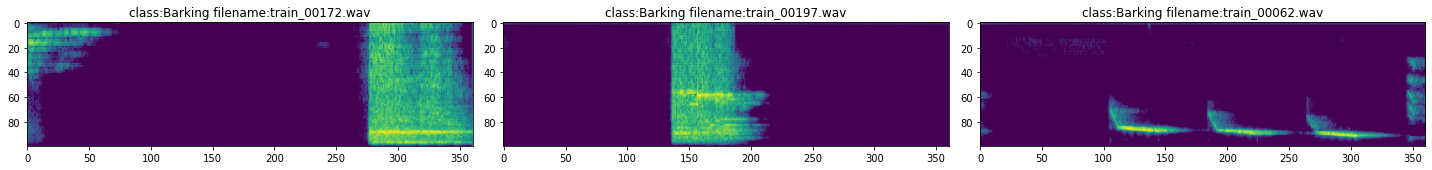

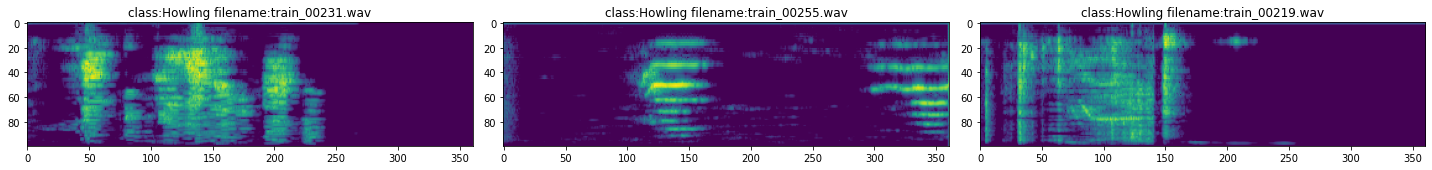

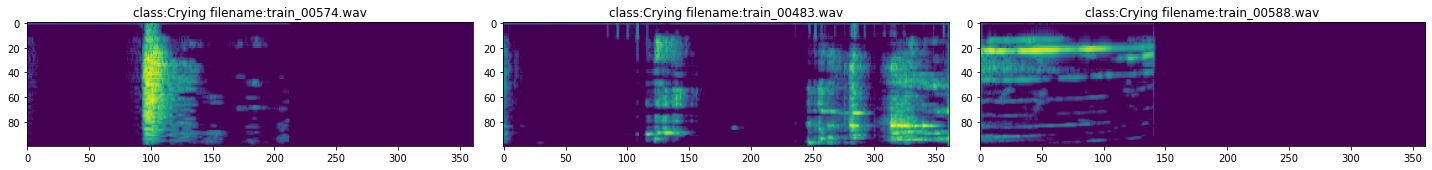

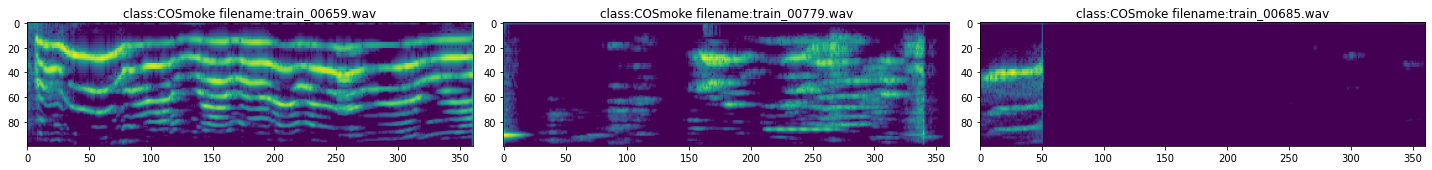

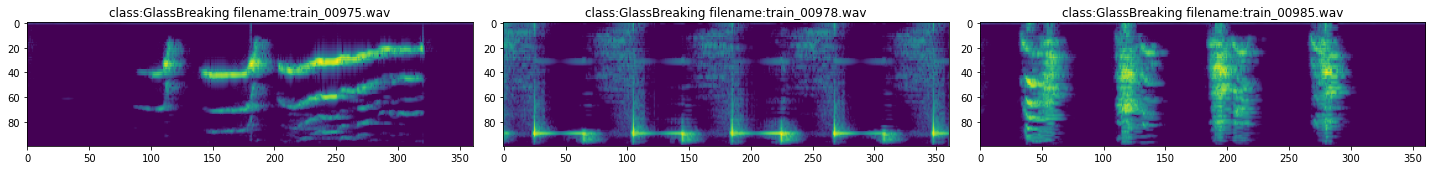

Other


<Figure size 1440x360 with 0 Axes>

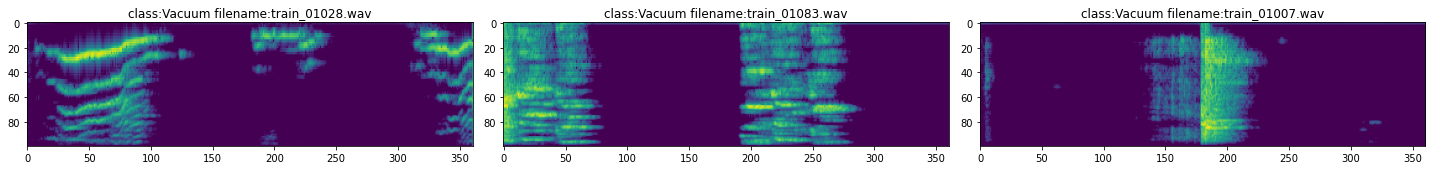

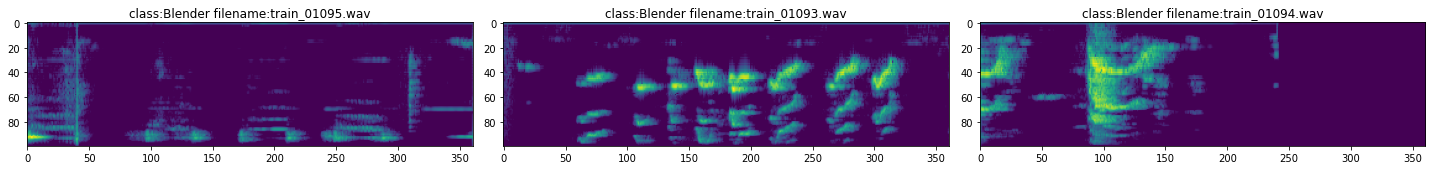

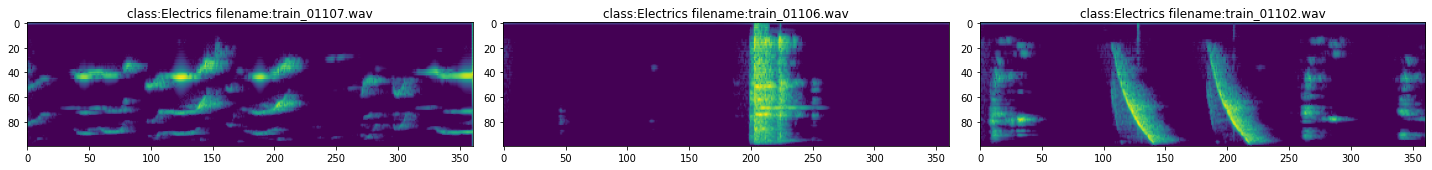

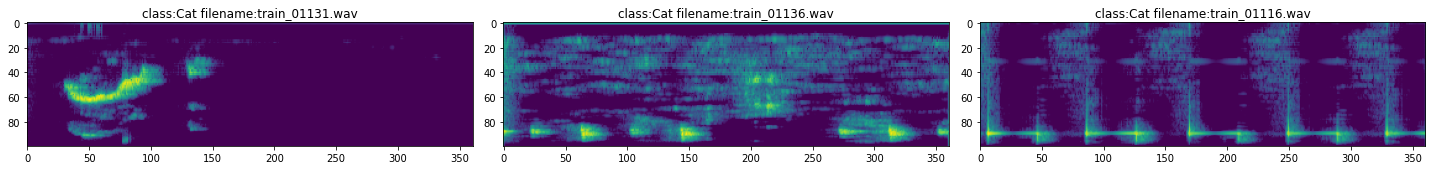

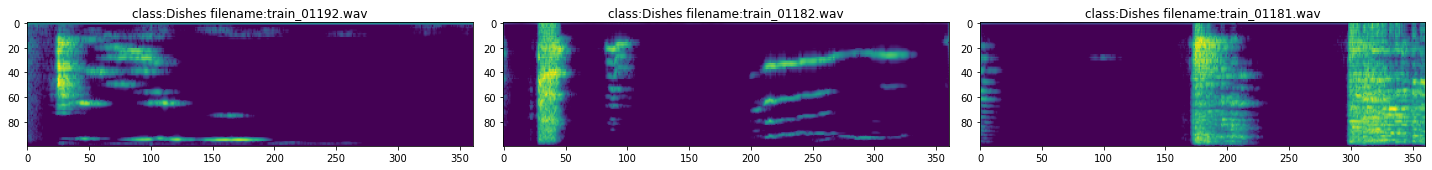

In [114]:
for class_name in Y_train_df.Remark.unique():
    plot_feature_by_class_name(class_name,X_train,Y_train_df)

# train valid split

In [115]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42,stratify=Y_train)
print(pd.DataFrame(y_train.argmax(axis=1)).value_counts())
print(pd.DataFrame(y_valid.argmax(axis=1)).value_counts())

5    804
0    800
1    800
2    800
3    800
4    796
dtype: int64
5    201
0    200
1    200
2    200
3    200
4    199
dtype: int64


#  create pytorch dataloader and save

In [116]:
X_train = X_train.to(torch.float32)
X_valid = X_valid.to(torch.float32)

In [117]:
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(torch.FloatTensor(X_train),torch.FloatTensor(y_train))
vaildset = TensorDataset(torch.FloatTensor(X_valid),torch.FloatTensor(y_valid))
train_iter = DataLoader(trainset,batch_size=128,num_workers=4)
vaild_iter = DataLoader(vaildset,batch_size=128,num_workers=4)
torch.save(train_iter, 'train_iter.pt')
torch.save(vaild_iter, 'vaild_iter.pt')

In [118]:
train_iter = torch.load('train_iter.pt')
vaild_iter = torch.load('vaild_iter.pt')

In [119]:
for bx,by in train_iter:
    print(bx.shape) # batch,channel,freq,time
    print(by.shape) # batch,n_class
    break

torch.Size([128, 1, 100, 361])
torch.Size([128, 6])


# define model

In [120]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*22*87,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,6)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = x.view(-1,16*22*87)
        x = F.dropout(x,p=0.25)
        x = F.relu(self.fc1(x))
        x = F.dropout(x,p=0.25)
        x = F.relu(self.fc2(x))
        x = F.dropout(x,p=0.25)
        x = F.softmax(self.fc3(x))
        return x
    
    def look_feature_map(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        return x
#model = LeNet()

# model forward test

In [121]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=512, out_features=6, bias=True)
y_hat = model(bx)
print(bx.shape)
print(y_hat.shape)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


torch.Size([128, 1, 100, 361])
torch.Size([128, 6])


# def train loop

In [123]:
def train_step(model,train_iter,loss_fn,optimizer):
        model.train()
        total_loss = 0
        total_auc = 0
        for t,(x,y) in enumerate(train_iter):
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            total_auc += calculate_auc_score(model,x,y)
            loss = loss_fn(y_hat,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        return total_loss/(t+1) ,total_auc/(t+1)

def valid_step(model,vaild_iter,loss_fn,optimizer):
    model.eval()
    total_loss = 0
    total_auc = 0
    for t,(x,y) in enumerate(vaild_iter):
        x,y = x.to(device),y.to(device)
        y_hat = model(x)
        total_auc += calculate_auc_score(model,x,y)
        loss = loss_fn(y_hat,y)
        total_loss += loss.item()
    return total_loss/(t+1) ,total_auc/(t+1)

def softmax2onehot(probs):
  probs = torch.FloatTensor(probs)
  max_idx = torch.argmax(probs, 1, keepdim=True)
  one_hot = torch.FloatTensor(probs.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  return one_hot.detach().cpu().numpy().astype(int)

# calculate roc_auc_score
def calculate_auc_score(model,x,y):
    y_hat = model(x).detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    return 0 #roc_auc_score(y_hat,y)


# train_loop
def train(model,optimizer,loss_fn,max_epochs=300,log_interval=10):
        history = {
            'train_loss':[],
            'valid_loss':[],
            'train_auc':[],
            'valid_auc':[],
            }
        current_loss = np.inf
        best_model = None
        for i in tqdm(range(max_epochs)):
            # step
            train_loss,train_auc = train_step(model,train_iter,loss_fn,optimizer)
            valid_loss,valid_auc = valid_step(model,vaild_iter,loss_fn,optimizer)
            # record history
            history['train_loss'].append(train_loss)
            history['valid_loss'].append(valid_loss)
            history['train_auc'].append(train_auc)
            history['valid_auc'].append(valid_auc)
            # print info
            if i % log_interval == 0:
                print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f} train_auc:{:.4f} valid_auc:{:.4f}".format(
                    i,history['train_loss'][-1],history['valid_loss'][-1],history['train_auc'][-1],history['valid_auc'][-1])
                    )
            # record the best model
            if history['valid_loss'][-1] <= current_loss:
                best_model = deepcopy(model.eval())
                current_loss = history['valid_loss'][-1]
        # copy best model
        model = deepcopy(best_model.eval())
        
        # plot
        plt.plot(history['train_loss'],label='train_loss')
        plt.plot(history['valid_loss'],label='valid_loss')
        plt.legend()
        plt.savefig('loss.jpg')
        plt.show()
        
        
        plt.plot(history['train_auc'],label='train_auc')
        plt.plot(history['valid_auc'],label='valid_auc')
        plt.legend()
        plt.savefig('auc.jpg')
        plt.show()
        
        
        return model







  0%|          | 0/100 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  







  1%|          | 1/100 [00:07<12:50,  7.79s/it]

epoch:0 train_loss:0.4623 valid_loss:0.4563 train_auc:0.0000 valid_auc:0.0000








  2%|▏         | 2/100 [00:15<12:48,  7.84s/it]





  3%|▎         | 3/100 [00:23<12:35,  7.79s/it]





  4%|▍         | 4/100 [00:31<12:29,  7.81s/it]





  5%|▌         | 5/100 [00:39<12:23,  7.82s/it]





  6%|▌         | 6/100 [00:47<12:17,  7.85s/it]





  7%|▋         | 7/100 [00:54<12:01,  7.76s/it]





  8%|▊         | 8/100 [01:02<11:56,  7.79s/it]





  9%|▉         | 9/100 [01:10<11:45,  7.75s/it]





 10%|█         | 10/100 [01:17<11:33,  7.71s/it]





 11%|█         | 11/100 [01:25<11:28,  7.74s/it]

epoch:10 train_loss:0.0009 valid_loss:0.0030 train_auc:0.0000 valid_auc:0.0000








 12%|█▏        | 12/100 [01:33<11:15,  7.68s/it]





 13%|█▎        | 13/100 [01:41<11:38,  8.03s/it]





 14%|█▍        | 14/100 [01:49<11:23,  7.94s/it]





 15%|█▌        | 15/100 [01:57<11:06,  7.84s/it]





 16%|█▌        | 16/100 [02:05<11:00,  7.86s/it]





 17%|█▋        | 17/100 [02:12<10:47,  7.80s/it]





 18%|█▊        | 18/100 [02:20<10:40,  7.81s/it]





 19%|█▉        | 19/100 [02:28<10:27,  7.75s/it]





 20%|██        | 20/100 [02:35<10:18,  7.73s/it]





 21%|██        | 21/100 [02:43<10:14,  7.78s/it]

epoch:20 train_loss:0.0001 valid_loss:0.0023 train_auc:0.0000 valid_auc:0.0000








 22%|██▏       | 22/100 [02:51<10:04,  7.76s/it]





 23%|██▎       | 23/100 [02:59<09:58,  7.77s/it]





 24%|██▍       | 24/100 [03:07<09:52,  7.79s/it]





 25%|██▌       | 25/100 [03:14<09:38,  7.71s/it]





 26%|██▌       | 26/100 [03:22<09:34,  7.76s/it]





 27%|██▋       | 27/100 [03:30<09:27,  7.77s/it]





 28%|██▊       | 28/100 [03:39<09:40,  8.06s/it]





 29%|██▉       | 29/100 [03:47<09:31,  8.05s/it]





 30%|███       | 30/100 [03:55<09:22,  8.03s/it]





 31%|███       | 31/100 [04:03<09:13,  8.03s/it]

epoch:30 train_loss:0.0001 valid_loss:0.0022 train_auc:0.0000 valid_auc:0.0000








 32%|███▏      | 32/100 [04:10<08:57,  7.91s/it]





 33%|███▎      | 33/100 [04:18<08:51,  7.93s/it]





 34%|███▍      | 34/100 [04:26<08:40,  7.89s/it]





 35%|███▌      | 35/100 [04:34<08:30,  7.86s/it]





 36%|███▌      | 36/100 [04:42<08:19,  7.81s/it]





 37%|███▋      | 37/100 [04:49<08:12,  7.82s/it]





 38%|███▊      | 38/100 [04:57<08:05,  7.84s/it]





 39%|███▉      | 39/100 [05:05<08:00,  7.88s/it]





 40%|████      | 40/100 [05:13<07:50,  7.85s/it]





 41%|████      | 41/100 [05:21<07:43,  7.85s/it]

epoch:40 train_loss:0.0000 valid_loss:0.0023 train_auc:0.0000 valid_auc:0.0000








 42%|████▏     | 42/100 [05:28<07:30,  7.77s/it]





 43%|████▎     | 43/100 [05:36<07:19,  7.71s/it]





 44%|████▍     | 44/100 [05:45<07:30,  8.04s/it]





 45%|████▌     | 45/100 [05:53<07:16,  7.94s/it]





 46%|████▌     | 46/100 [06:01<07:11,  7.98s/it]





 47%|████▋     | 47/100 [06:08<06:59,  7.91s/it]





 48%|████▊     | 48/100 [06:16<06:48,  7.85s/it]





 49%|████▉     | 49/100 [06:24<06:38,  7.81s/it]





 50%|█████     | 50/100 [06:31<06:28,  7.77s/it]





 51%|█████     | 51/100 [06:39<06:21,  7.78s/it]

epoch:50 train_loss:0.0000 valid_loss:0.0024 train_auc:0.0000 valid_auc:0.0000








 52%|█████▏    | 52/100 [06:47<06:11,  7.73s/it]





 53%|█████▎    | 53/100 [06:55<06:04,  7.75s/it]





 54%|█████▍    | 54/100 [07:02<05:56,  7.76s/it]





 55%|█████▌    | 55/100 [07:10<05:47,  7.73s/it]





 56%|█████▌    | 56/100 [07:18<05:42,  7.79s/it]





 57%|█████▋    | 57/100 [07:26<05:33,  7.76s/it]





 58%|█████▊    | 58/100 [07:34<05:26,  7.77s/it]





 59%|█████▉    | 59/100 [07:41<05:20,  7.81s/it]





 60%|██████    | 60/100 [07:50<05:20,  8.01s/it]





 61%|██████    | 61/100 [07:58<05:10,  7.96s/it]

epoch:60 train_loss:0.0000 valid_loss:0.0025 train_auc:0.0000 valid_auc:0.0000








 62%|██████▏   | 62/100 [08:05<04:59,  7.88s/it]





 63%|██████▎   | 63/100 [08:13<04:51,  7.88s/it]





 64%|██████▍   | 64/100 [08:21<04:42,  7.83s/it]





 65%|██████▌   | 65/100 [08:29<04:31,  7.76s/it]





 66%|██████▌   | 66/100 [08:37<04:25,  7.80s/it]





 67%|██████▋   | 67/100 [08:44<04:15,  7.75s/it]





 68%|██████▊   | 68/100 [08:52<04:06,  7.69s/it]





 69%|██████▉   | 69/100 [08:59<03:58,  7.70s/it]





 70%|███████   | 70/100 [09:07<03:50,  7.69s/it]





 71%|███████   | 71/100 [09:15<03:43,  7.70s/it]

epoch:70 train_loss:0.0000 valid_loss:0.0026 train_auc:0.0000 valid_auc:0.0000








 72%|███████▏  | 72/100 [09:22<03:34,  7.65s/it]





 73%|███████▎  | 73/100 [09:30<03:27,  7.69s/it]





 74%|███████▍  | 74/100 [09:38<03:21,  7.75s/it]





 75%|███████▌  | 75/100 [09:46<03:18,  7.93s/it]





 76%|███████▌  | 76/100 [09:54<03:11,  7.98s/it]





 77%|███████▋  | 77/100 [10:02<03:02,  7.93s/it]





 78%|███████▊  | 78/100 [10:10<02:53,  7.88s/it]





 79%|███████▉  | 79/100 [10:18<02:46,  7.91s/it]





 80%|████████  | 80/100 [10:26<02:36,  7.85s/it]





 81%|████████  | 81/100 [10:34<02:29,  7.89s/it]

epoch:80 train_loss:0.0000 valid_loss:0.0027 train_auc:0.0000 valid_auc:0.0000








 82%|████████▏ | 82/100 [10:41<02:21,  7.83s/it]





 83%|████████▎ | 83/100 [10:49<02:13,  7.85s/it]





 84%|████████▍ | 84/100 [10:57<02:05,  7.84s/it]





 85%|████████▌ | 85/100 [11:05<01:56,  7.77s/it]





 86%|████████▌ | 86/100 [11:13<01:49,  7.85s/it]





 87%|████████▋ | 87/100 [11:21<01:41,  7.82s/it]





 88%|████████▊ | 88/100 [11:28<01:32,  7.74s/it]





 89%|████████▉ | 89/100 [11:36<01:25,  7.75s/it]





 90%|█████████ | 90/100 [11:44<01:17,  7.75s/it]





 91%|█████████ | 91/100 [11:52<01:12,  8.10s/it]

epoch:90 train_loss:0.0000 valid_loss:0.0028 train_auc:0.0000 valid_auc:0.0000








 92%|█████████▏| 92/100 [12:00<01:04,  8.05s/it]





 93%|█████████▎| 93/100 [12:09<00:56,  8.08s/it]





 94%|█████████▍| 94/100 [12:16<00:48,  8.01s/it]





 95%|█████████▌| 95/100 [12:24<00:39,  7.98s/it]





 96%|█████████▌| 96/100 [12:32<00:31,  7.89s/it]





 97%|█████████▋| 97/100 [12:40<00:23,  7.87s/it]





 98%|█████████▊| 98/100 [12:48<00:15,  7.91s/it]





 99%|█████████▉| 99/100 [12:56<00:07,  7.93s/it]





100%|██████████| 100/100 [13:04<00:00,  7.84s/it]


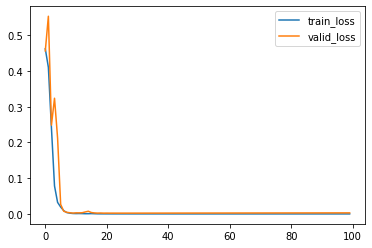

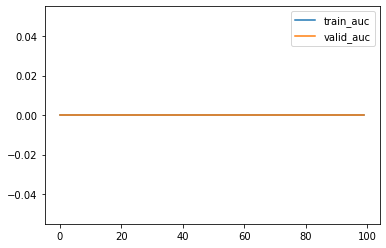

train done


In [124]:
device = 'cuda:0'
model = model.to(device)
print(model)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])
optimizer = Adam(model.parameters(),lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
model = train(model,optimizer,loss_fn,max_epochs=100,log_interval=10)
torch.save(model,'model.pt')
print('train done')

# model infernce test

In [125]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model,data_iter,map_dict=map_dict):
    y_true = np.array([])
    y_pred = np.array([])
    for bx,by in tqdm(data_iter):
        bx = bx.to(device)
        by = by.to(device)
        y_hat = model(bx)
        try:
            if len(y_true) == 0:
                y_true = by.argmax(axis=1).detach().cpu().numpy()
                y_pred = y_hat.argmax(axis=1).detach().cpu().numpy()
            else:
                y_true = np.hstack((y_true,by.argmax(axis=1).detach().cpu().numpy()))
                y_pred = np.hstack((y_pred,y_hat.argmax(axis=1).detach().cpu().numpy()))
        except:
            pass
    cm = pd.DataFrame(confusion_matrix(y_pred,y_true))
    cm.columns = list(map_dict.values())
    return cm

In [126]:
cm = plot_confusion_matrix(model,train_iter)
cm.style.background_gradient()







  0%|          | 0/38 [00:00<?, ?it/s]





  3%|▎         | 1/38 [00:01<00:46,  1.26s/it]





 13%|█▎        | 5/38 [00:01<00:29,  1.12it/s]





 24%|██▎       | 9/38 [00:01<00:18,  1.58it/s]





 34%|███▍      | 13/38 [00:01<00:11,  2.22it/s]





 45%|████▍     | 17/38 [00:01<00:06,  3.08it/s]





 55%|█████▌    | 21/38 [00:01<00:04,  4.23it/s]





 66%|██████▌   | 25/38 [00:01<00:02,  5.73it/s]





 76%|███████▋  | 29/38 [00:02<00:01,  7.60it/s]





 87%|████████▋ | 33/38 [00:02<00:00,  9.92it/s]





100%|██████████| 38/38 [00:02<00:00, 14.28it/s]


In [127]:
cm = plot_confusion_matrix(model,vaild_iter)
cm.style.background_gradient()







  0%|          | 0/10 [00:00<?, ?it/s]





 10%|█         | 1/10 [00:01<00:11,  1.22s/it]





 40%|████      | 4/10 [00:01<00:05,  1.15it/s]





100%|██████████| 10/10 [00:01<00:00,  5.45it/s][A


In [128]:
model = model.to('cpu')
torch.save(model,'model.pt')
print('model save done')

model save done


# submit

In [129]:
# load model
model = torch.load('model.pt').cuda()
print('use model is:',model)

# test_data_dir
test_data_dir = 'public_test/public_test/'

# inference for loop
files = os.listdir(test_data_dir)
n = 10000
sample_submit = pd.read_csv('sample_submission.csv')
i = 0
for f in tqdm(files[:n]):
    samples, sample_rate = librosa.load(test_data_dir+f,sr=16000)
    mel_spectrogram = sample2melspectrogram(samples,sample_rate)
    shape = mel_spectrogram.shape
    mel_spectrogram = np.reshape(mel_spectrogram, (-1, shape[0], shape[1]))
    mel_spectrogram = torch.from_numpy(mel_spectrogram)
    X = torch.unsqueeze(mel_spectrogram,0).to(torch.float32).cuda()
    y_hat = model(X).detach().cpu().numpy()
    sample_submit.iloc[[i],1:] = y_hat
    i += 1
    gc.collect()

# save
sample_submit.to_csv('submit.csv',index=False)
print('done')







  0%|          | 0/10000 [00:00<?, ?it/s]

use model is: DataParallel(
  (module): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi







  0%|          | 1/10000 [00:00<1:02:20,  2.67it/s]





  0%|          | 2/10000 [00:00<55:22,  3.01it/s]  





  0%|          | 3/10000 [00:00<52:43,  3.16it/s]





  0%|          | 4/10000 [00:01<50:26,  3.30it/s]





  0%|          | 5/10000 [00:01<47:17,  3.52it/s]





  0%|          | 6/10000 [00:01<46:04,  3.62it/s]





  0%|          | 7/10000 [00:01<43:33,  3.82it/s]





  0%|          | 8/10000 [00:02<43:16,  3.85it/s]





  0%|          | 9/10000 [00:02<41:50,  3.98it/s]





  0%|          | 10/10000 [00:02<40:58,  4.06it/s]





  0%|          | 11/10000 [00:02<41:53,  3.97it/s]





  0%|          | 12/10000 [00:03<40:52,  4.07it/s]





  0%|          | 13/10000 [00:03<41:44,  3.99it/s]





  0%|          | 14/10000 [00:03<41:08,  4.04it/s]





  0%|          | 15/10000 [00:03<41:36,  4.00it/s]





  0%|          | 16/10000 [00:04<41:01,  4.06it/s]





  0%|          | 17/10000 [00:04<42:22,  3.93it/s]





  0%|          | 18/10000 [00:04<41:48,  3.98it

done
